# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
trainingFile = 'traffic-signs-data/train.p'
testingFile = 'traffic-signs-data/test.p'

with open(trainingFile, mode='rb') as f:
    train = pickle.load(f)
with open(testingFile, mode='rb') as f:
    test = pickle.load(f)
    
xTrain, yTrain = train['features'], train['labels']
xTest, yTest = test['features'], test['labels']

In [3]:
print(len(train['features']))
print(train['features'].shape)
print(len(train['labels']))
print(train['labels'].shape)

39209
(39209, 32, 32, 3)
39209
(39209,)


In [4]:
print(type(train['labels'][0]))
print(np.count_nonzero(train['labels'] == 0)) 

<class 'numpy.uint8'>
210


In [5]:
# visualize the dataset
print('features in the train set has size of',train['features'].shape)
print('features in the test set has size of',test['features'].shape)
print('labels in the train set has size of',train['labels'].shape)
print('labels in the test set has size of',test['labels'].shape)
print('sizes in the train set has size of',train['sizes'].shape)
print('sizes in the test set has size of',test['sizes'].shape)
print('coords in the train set has size of',train['coords'].shape)
print('coords in the test set has size of',test['coords'].shape)
print('We have',len(np.unique(train['labels'])),'unique class in our train set')

features in the train set has size of (39209, 32, 32, 3)
features in the test set has size of (12630, 32, 32, 3)
labels in the train set has size of (39209,)
labels in the test set has size of (12630,)
sizes in the train set has size of (39209, 2)
sizes in the test set has size of (12630, 2)
coords in the train set has size of (39209, 4)
coords in the test set has size of (12630, 4)
We have 43 unique class in our train set


In [6]:
### To start off let's do a basic data summary.
# total: 50000 40 classes
# train size: 39209 RGB
# test size: 12630
# TODO: number of training examples
nTrain = 39209

# TODO: number of testing examples
nTest = 12630

# TODO: what's the shape of an image?
# imageShape = [32,32,1]

# TODO: how many classes are in the dataset
nClasses = len(np.unique(train['labels']))

print("Number of training examples =", nTrain)
print("Number of testing examples =", nTest)
#print("Image data shape =", imageShape)
print("Number of classes =", nClasses)

Number of training examples = 39209
Number of testing examples = 12630
Number of classes = 43


In [7]:
import csv
fileName = 'signnames.csv'
csvFile = open(fileName,'r')
titleReader = csv.DictReader(csvFile, delimiter=',')
imgTitles = []
for row in titleReader:
    imgTitles.append(row['SignName'])

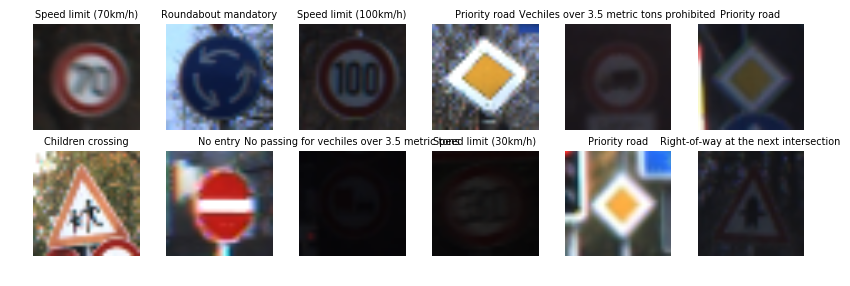

In [8]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# plotting traffic signs images
%matplotlib inline
samples2Visualize = 12 # sample 10 random number
factors = [2,6] # indicate two factors for number of samples
assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
figure = plt.figure(figsize=(10,3))
for i in range(1,samples2Visualize+1):
    img = figure.add_subplot(factors[0],factors[1],i)
    # randomly sample an image from train set
    imgID = np.random.randint(nTrain-1)
    plt.imshow(train['features'][imgID])
    img.set_title(imgTitles[train['labels'][imgID]],fontsize=7)
    plt.axis('off')

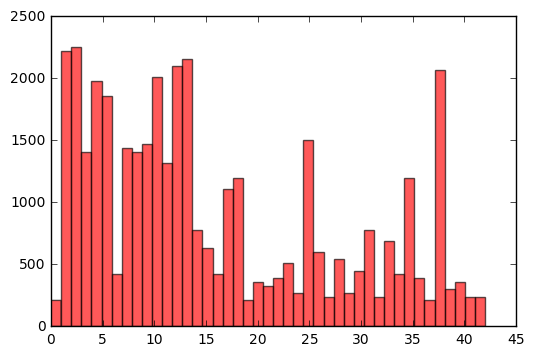

In [9]:
# plotting the count of each sign
histOut = plt.hist(train['labels'],nClasses, facecolor='r', alpha=0.65)
# so this is a very unbalnced dataset I think we need to fix this somehow

In [133]:
# Get the features and labels to work with them
trainFeatures, trainLabels = train['features'], train['labels']
testFeatures, testLabels = test['features'], train['labels']

In [144]:
''' Src: http://www.kdnuggets.com/2016/03/must-know-tips-deep-learning-part-1.html
Since deep networks need to be trained on a huge number of training images 
to achieve satisfactory performance, if the original image data set contains 
limited training images, it is better to do data augmentation to boost the 
performance. Also, data augmentation becomes the thing must to do when 
training a deep network.
'''
import skimage 
# my algorithms for over sampling
overSampling = True
underSampling = False
maxClassesNum = max(histOut[0])
avgClassesNum = np.mean(histOut[0])
avgClassesNum = 5000 # generating more data in case if you need more data
originShape = trainFeatures.shape
trainFeaturesNew = trainFeatures
trainLabelsNew = trainLabels
for i in range(nClasses):
    if overSampling:
        if histOut[0][i] < avgClassesNum:
            # randomly generate new samples
            diff = avgClassesNum - histOut[0][i]
            diff -= np.random.randint(-500,500)
            xIndex = np.where(trainLabels == i)
            xIndexSize = xIndex[0].shape[0]
            if xIndexSize==0: # is it possible?! Why? :/ Oh, I think I know what is the problem :D
                continue
            for j in range(int(diff)):
                newImgIdx = xIndex[0][np.random.randint(xIndexSize-1)]
                newImg = trainFeatures[newImgIdx,:]
                # CNN is a translaltion invariance so 
                # I choose random affine rotation to have 
                # a new image
                # http://docs.opencv.org/3.1.0/da/d6e/tutorial_py_geometric_transformations.html
                rows,cols,_ = newImg.shape
                angle = np.random.randint(-20,20)
                M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
                
                # I add shear because I saw in my special test case(my camera) almost all of them are the sheared one :|
                # so network need to see some kind of them before we want him to predict ;D
                src = np.float32([[1,1],[10,1],[1,10]])
                point1 = 1+np.random.randint(-2,2) 
                point2 = 10+np.random.randint(-3,3)
                dist = np.float32([[point1,1],[point2,point1],[1,point2]])
                shearM = cv2.getAffineTransform(src,dist)
                #newImg = cv2.warpAffine(newImg,shearM,(cols,rows)) # shear
                
                transM = np.float32([[1,0,np.random.randint(-4,4)],[0,1,np.random.randint(-4,4)]])
                
                newImg = cv2.warpAffine(newImg,M,(cols,rows)) # rotate
                newImg = cv2.warpAffine(newImg,shearM,(cols,rows)) # shear
                
                newImg = cv2.warpAffine(newImg,transM, (cols,rows))
                
                # white gauassian noise
                # newImg = skimage.util.random_noise(newImg, mode='gaussian',var=0.001) # very little noise to prevent overfitting
                #plt.imshow(newImg)
                # source: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
                # Randomly adjust hue, contrast and saturation.
                '''newImg = tf.image.random_hue(newImg, max_delta=0.05)
                newImg = tf.image.random_contrast(newImg, lower=0.3, upper=1.0)
                newImg = tf.image.random_brightness(newImg, max_delta=0.2)
                newImg = tf.image.random_saturation(newImg, lower=0.0, upper=2.0)'''
                # Limit the image pixels between [0, 1] in case of overflow.
                #plt.imshow(newImg)
                #break
                #break
                #break
                #newImg = tf.minimum(newImg, 1.0)
                #newImg = tf.maximum(newImg, 0.0)

                trainFeaturesNew = np.insert(trainFeaturesNew,newImgIdx,newImg,axis=0)
                trainLabelsNew = np.insert(trainLabelsNew,newImgIdx,i,axis=0)            
    if underSampling:
        if histOut[0][i] > avgClassesNum:
            print('not Implemented yet')         

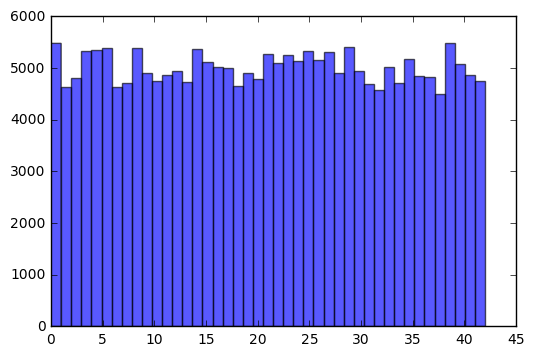

In [145]:
histNew = plt.hist(trainLabelsNew,nClasses, facecolor='b', alpha=0.65)
trainFeatures = trainFeaturesNew
trainLabels = trainLabelsNew

In [146]:
np.save('./augmentedTrainFeatures5001', trainFeatures)
np.save('./augmentedTrainLabels5001', trainLabels)

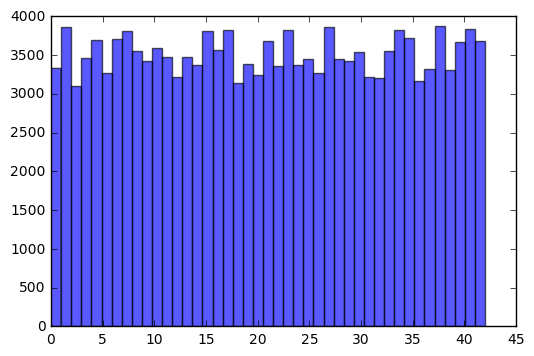

In [117]:
# load augmented data for saving times
trainFeatures = np.load('./augmentedTrainFeatures.npy')
trainLabels = np.load('./augmentedTrainLabels.npy')
histNew = plt.hist(trainLabels,nClasses, facecolor='b', alpha=0.65)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Downsampling and UpSampling 
# all images are already 32 by 32 so we don't need this part anymore

# YUV Space
''' Src: http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
The Y channel isthen preprocessed with global and local contrast normal-
ization while U and V channels are left unchanged. Global normalization
first centers each image around its mean value whereas local normalization emphasizes edges
'''
'''
# RGB 2 BGR? Check later if I have to use this
def rgb2BGR(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
trainFeatures = np.array([rgb2BGR(image) for image in trainFeatures], dtype=np.float32)
testFeatures = np.array([rgb2BGR(image) for image in testFeatures], dtype=np.float32)
'''
# BGR 2 YUV
def bgr2YUV(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV) 
trainFeatures = np.array([bgr2YUV(image) for image in trainFeatures], dtype=np.float32)
testFeatures = np.array([bgr2YUV(image) for image in testFeatures], dtype=np.float32)

# main Idea: https://www.packtpub.com/mapt/book/Application-Development/9781785283932/2/ch02lvl1sec26/Enhancing%20the%20contrast%20in%20an%20image
def equlizeYUV(image):
    # http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
    image[:,:,0] = clahe.apply(image[:,:,0].astype(np.uint8)) # local normalization
    # global Normalization
    # image[:,:,0] = cv2.equalizeHist(image.astype(np.uint8)[:,:,0]) # only Y channel
    return image
trainFeatures = np.array([equlizeYUV(image) for image in trainFeatures], dtype=np.float32)
testFeatures = np.array([equlizeYUV(image) for image in testFeatures], dtype=np.float32)

# YUV 2 BGR 
def yuv2BGR(image):
    return cv2.cvtColor(image, cv2.COLOR_YUV2BGR) 
# trainFeatures = np.array([yuv2BGR(image) for image in trainFeatures], dtype=np.float32)
# testFeatures = np.array([yuv2BGR(image) for image in testFeatures], dtype=np.float32)

'''# RGB 2 BGR? Check later if I have to use this
def bgr2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
trainFeatures = np.array([bgr2RGB(image) for image in trainFeatures], dtype=np.float32)
testFeatures = np.array([bgr2RGB(image) for image in testFeatures], dtype=np.float32)'''

In [150]:
print(trainFeatures.shape)

(215052, 32, 32, 3)


In [119]:
# best normalization solution untill now - only use this one
def normalizeRGBCV2(image):
    return cv2.normalize(image, None, 0.0, 1.1, cv2.NORM_MINMAX, cv2.CV_32F)
trainFeatures = np.array([normalizeRGBCV2(image) for image in trainFeatures], dtype=np.float32)
testFeatures = np.array([normalizeRGBCV2(image) for image in testFeatures], dtype=np.float32)

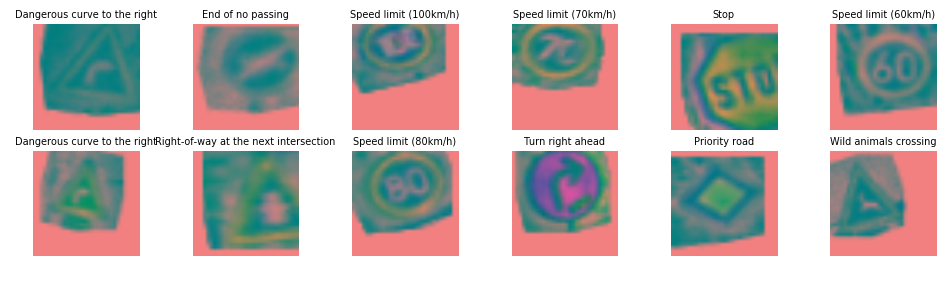

In [151]:
# visualize dataset after normalization
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# plotting traffic signs images
%matplotlib inline
samples2Visualize = 12 # sample 10 random number
factors = [2,6] # indicate two factors for number of samples
assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
figure = plt.figure(figsize=(12,3))
for i in range(1,samples2Visualize+1):
    img = figure.add_subplot(factors[0],factors[1],i)
    # randomly sample an image from train set
    imgID = np.random.randint(nTrain-1)
    #plt.imshow(trainFeatures[imgID][:,:,0], cmap=plt.get_cmap('gray')) # Y channel
    
    plt.imshow(trainFeatures[imgID])

    img.set_title(imgTitles[trainLabels[imgID]],fontsize=7)
    plt.axis('off')

In [152]:
print(trainLabels) # before encode labels into one hot

[ 0  0  0 ..., 42 42 42]


In [153]:
import os
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(trainLabels)
trainLabels = encoder.transform(trainLabels)
testLabels = encoder.transform(testLabels)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
trainLabels = trainLabels.astype(np.float32)
testLabels = testLabels.astype(np.float32)
isLabelsEncod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [154]:
print(trainLabels) # after encoding

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** I used various techniques to have more experiment and see what is the best way however because I had no access to a great GPU in the time, it was very hard and time-consuming to experiment these aproaches in many many time however with my current situations I think I did my best. I think my best result for my third model (current) was Yann Lecun proposed method which I converted the color from BGR/RGB to YUV and then normalized Y channel globally and locally. I test two RGB normalization and even I wanted to sse what will be the result for grayscale images. Although I know CNN was design to extract features automatically and we don't really need to select and remove some of information (for example delete light and shadow through normalizing) and if CNN is powerful enough can extract great features however I just wanna have experiment with various scenario. And using this preprocess technique such as max-min normalization we will scale the image between 0 and 1 which means we simplify the problem for the network. 

The original problem is an umbalanced one and this means the model will be biased to classess with more data so I generated and augmented more data from each class to prevent overfitting and solve the imbalancing problem. I used random gaussian noise, randomly translating an image, randomly shearing an image and randomly rotating an image which help the model to see more general and different scenario and avoid overfitting and avoid bias problem. 

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.



In [155]:
# Get randomized datasets for training and validation
trainFeatures, validFeatures, trainLabels, validLabels = train_test_split(
    trainFeatures,
    trainLabels,
    test_size=0.2,
    random_state=832289)

print('Training features and labels randomized and split.')
print(trainFeatures.shape, validFeatures.shape, trainLabels.shape, validLabels.shape)


Training features and labels randomized and split.
(172041, 32, 32, 3) (43011, 32, 32, 3) (172041, 43) (43011, 43)


In [156]:
imageShape = trainFeatures[0].shape
print(imageShape)
if(len(imageShape)<3):
    imageShape = list(imageShape)
    imageShape.append(1)
    imageShape = tuple(imageShape)
print(imageShape)  

(32, 32, 3)
(32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** As I said in the previous question I generated more data to solve the imbalancing prblem and avoid overfitting. I used 172041 sample as training sample, 43011 for validation stage and 12630 sample as a test set. I choose train-validation set ratio 80/20 because it seems to me it is enough to train the model and valid it. I used train-test-split function in python. 

In [157]:
def weightVariable(shape): # generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients
    initial = tf.truncated_normal(shape, stddev=0.0001)
    return tf.Variable(initial)

def biasVariable(shape): # Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons".
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    # x = tf.nn.bias_add(x, b) # remove bias to prevent overfitting
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

In [158]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

# Architecture
layerWidth = {
    'layer11': 64,
    'layer12': 64,
    'layer13': 64,
    'layer21': 128,
    'layer22': 128,
    'layer23': 128,
    'layer31': 256,
    'layer32': 256,
    'layer33': 256,
    'fc1': 1024,
    'fc2': 512
}

# Store layers weight & bias
weights ={
    'layer11': tf.Variable(tf.truncated_normal(
        [3, 3, 1, layerWidth['layer11']])),  
    'layer12': tf.Variable(tf.truncated_normal(
        [3, 3, 1, layerWidth['layer12']])),
    'layer13': tf.Variable(tf.truncated_normal(
        [3, 3, 1, layerWidth['layer13']])), 
    'layer21': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer11'], layerWidth['layer21']])),
    'layer22': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer12'], layerWidth['layer22']])), 
    'layer23': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer13'], layerWidth['layer23']])),
    'layer31': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer21'], layerWidth['layer31']])), 
    'layer32': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer22'], layerWidth['layer32']])),
    'layer33': tf.Variable(tf.truncated_normal(
        [3, 3, layerWidth['layer23'], layerWidth['layer33']])),
    'fc1': tf.Variable(tf.truncated_normal(
        [16*(layerWidth['layer31']+layerWidth['layer32']+layerWidth['layer33']), layerWidth['fc1']])),
    'fc2': tf.Variable(tf.truncated_normal(
        [layerWidth['fc1'], layerWidth['fc2']])),
    'out': tf.Variable(tf.truncated_normal(
        [layerWidth['fc2'], nClasses]))
}
biases = {
    'layer1': tf.Variable(tf.zeros(layerWidth['layer11'])),
    'layer2': tf.Variable(tf.zeros(layerWidth['layer21'])),
    'layer3': tf.Variable(tf.zeros(layerWidth['layer31'])),
    'layer4': tf.Variable(tf.zeros(layerWidth['layer12'])),
    'fc1': tf.Variable(tf.zeros(layerWidth['fc1'])),
    'fc2': tf.Variable(tf.zeros(layerWidth['fc2'])),
    'out': tf.Variable(tf.zeros(nClasses))
}

In [159]:
# Create model
def convNet(x, x1, x2, x3, y, weights, biases, dropMe,keepProb):
    # Layer 1 - 32*32*3 to 14*14*32 | in case of grayscale: 32*32*1
    '''x1 = x[:,:,:,0]
    x2 = x[:,:,:,1]
    x3 = x[:,:,:,2]'''
    
    
    conv11 = conv2d(x1, weights['layer11'], biases['layer1'])
    conv12 = conv2d(x2, weights['layer12'], biases['layer1'])
    conv13 = conv2d(x3, weights['layer13'], biases['layer1'])
    conv11 = maxpool2d(conv11)
    conv12 = maxpool2d(conv12)
    conv13 = maxpool2d(conv13)
    
    #conv1 = tf.nn.dropout(conv1, keep_prob=keepProb)
    
    #conv12 = conv2d(conv1, weights['layer12'], biases['layer1'])
    #conv1 = maxpool2d(conv12)

    # Layer 2 - 14*14*32 to 7*7*64
    conv21 = conv2d(conv11, weights['layer21'], biases['layer2'])
    conv22 = conv2d(conv12, weights['layer22'], biases['layer2'])
    conv23 = conv2d(conv13, weights['layer23'], biases['layer2'])
    conv21 = maxpool2d(conv21)
    conv22 = maxpool2d(conv22)
    conv23 = maxpool2d(conv23)
    
    #conv2 = tf.nn.dropout(conv2, keep_prob=keepProb)

    # Layer 3 - 7*7*64 to 4*4*128
    conv31 = conv2d(conv21, weights['layer31'], biases['layer3'])
    conv32 = conv2d(conv22, weights['layer32'], biases['layer3'])
    conv33 = conv2d(conv23, weights['layer33'], biases['layer3'])
    conv31 = maxpool2d(conv31)
    conv32 = maxpool2d(conv32)
    conv33 = maxpool2d(conv33)
    
    #conv31 = tf.nn.dropout(conv31, keep_prob=0.25)
    #conv32 = tf.nn.dropout(conv32, keep_prob=0.25)
    #conv33 = tf.nn.dropout(conv33, keep_prob=0.25)
    
    #print(conv3.get_shape)
    
    # Layer 4 - 4*4*128 to 2*2*256
    '''conv4 = conv2d(conv3, weights['layer4'], biases['layer4'])
    conv4 = conv2d(conv4, weights['layer42'], biases['layer4'])
    conv4 = maxpool2d(conv4)'''
    
    #conv4 = tf.nn.dropout(conv4, keep_prob=keepProb)
    
    #print(conv4.get_shape)
    # Fully connected layer - 2*2*256 to 1024
    # Reshape fc1 output to fit fully connected layer input
    
    # combine all convolution layer together
    fc1 = tf.nn.relu(tf.concat(3,[conv31,conv32,conv33])) # something similar to inception module
    fc1 = tf.reshape(fc1,[-1,weights['fc1'].get_shape().as_list()[0]])
    
    '''fc1 = tf.reshape(
        conv4,
        [-1, weights['fc1'].get_shape().as_list()[0]])'''
    #fc1 = tf.matmul(fc1, weights['fc1'])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fc1']),
        biases['fc1'])
    fc1 =  tf.nn.relu(fc1) 
    
    #if keepProb != 1.0:
    #    fc1 = tf.nn.dropout(fc1, keep_prob=keepProb)
    
    # Fully connected layer - 1024 to 512
    # Reshape fc1 output to fit fully connected layer input
    
    fc2 = tf.reshape(
        fc1,
        [-1, weights['fc2'].get_shape().as_list()[0]])
    fc2 = tf.add(
        tf.matmul(fc2, weights['fc2']),
        biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    
    
    #fc3 = tf.cond(dropMe, lambda: tf.nn.dropout(fc2,keepProb), lambda: fc2, name="dropoutAddCondition")
    fc3 = fc2
    
        #fc1 = tf.contrib.layers.l2_regularizer(fc1)
        
        #fc1 = tf.nn.dropout(fc1,keepProb)

    # Output Layer - class prediction - 1024 to 43
    #fc2 = tf.matmul(fc1, weights['out'])
    
    fc3 = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    #fc2 = tf.nn.relu(tf.add(tf.matmul(fc2, weights['out']), biases['out']))
    #fc2 = tf.nn.dropout(fc2, keep_prob=keepProb)

    
    
    #fc2 = tf.nn.dropout(fc2, keep_prob=keepProb)
    defaultReg = tf.constant(0.0, name="0.0")
    regularization = tf.cond(dropMe, lambda: tf.nn.l2_loss(weights['fc1']) + tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['fc1']) + tf.nn.l2_loss(biases['out']) , lambda: defaultReg, name="L2AddCondition")
        
    
    
    # softmax layer
    out = tf.nn.softmax(fc3)
    
    # Define loss and optimizer
    learningRate = 9e-4 # 9e-4: 88% 80 Epoch
    logits = fc3
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
    
    cost += tf.cond(dropMe, lambda:  1e-1 * regularization, lambda: defaultReg, name="costAddCondition")
         
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learningRate)\
        .minimize(cost)
    return (out, optimizer, cost)

In [160]:

batchSize = 512
trainingEpochs = 75 # 80 # Early Stopping

sess = tf.InteractiveSession()

dropMe = tf.placeholder(tf.bool,  name='dropoutCondition')
keepProb = tf.placeholder(tf.float32)

# tf Graph input
x = tf.placeholder("float", [None, 32, 32, imageShape[2]])
x1 = tf.placeholder("float", [None, 32, 32, 1])
x2 = tf.placeholder("float", [None, 32, 32, 1])
x3 = tf.placeholder("float", [None, 32, 32, 1])
y = tf.placeholder("float", [None, nClasses])

logits, optimizer, cost = convNet(x, x1, x2, x3, y, weights, biases,dropMe,keepProb)

# Initializing the variables
init = tf.initialize_all_variables()

#tf.scalar_summary("loss", cost)
#mergedSummary = tf.merge_all_summaries()
saver = tf.train.Saver()
#logsPath = './logs'
#summaryWriter = tf.train.SummaryWriter(logsPath, graph=tf.get_default_graph())
logModelDir = './save'

Epoch 75/75: 100%|██████████| 337/337 [04:56<00:00,  1.13batches/s]


Optimization Finished!


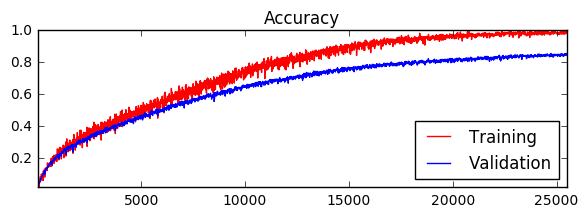

Model saved in file: ./save/model.ckpt


In [161]:
### Train your model here.
### Feel free to use as many code cells as needed.
# Launch the graph
import math
# Parameters
logBatchStep = 10
batchCount = int(math.ceil(len(trainFeatures)/batchSize))
#sess = tf.Session()
sess.run(init)
batches = []
trainBatch = []
validBatch = []
# Training cycle
#tf.reset_default_graph() # to reset everything

for epoch in range(trainingEpochs):
    # Progress bar
    batchesPBar = tqdm(range(batchCount), desc='Epoch {:>2}/{}'.format(epoch+1, trainingEpochs), unit='batches')
    # The training cycle
    for batchI in batchesPBar:
    #totalBatch = int(mnist.train.numExamples/batchSize)
    # Loop over all batches
    #for i in range(total_batch):
        # Get a batch of training features and labels
        batchStart = batchI*batchSize
        batchX = trainFeatures[batchStart:batchStart + batchSize,:]
        batchY = trainLabels[batchStart:batchStart + batchSize]
        #print(type(batchX))
        # Run optimization op (backprop) and cost op (to get loss value)
        
        batchX1 = np.array([batchX[:,:,:,0].T]).T
        batchX2 = np.array([batchX[:,:,:,1].T]).T
        batchX3 = np.array([batchX[:,:,:,2].T]).T
        
        #print(batchX1.shape)
        
        _,_,c = sess.run([logits,optimizer,cost], feed_dict={x: batchX,
                                                             x1: batchX1,
                                                             x2: batchX2,
                                                             x3: batchX3,
                                                             y: batchY, 
                                                             dropMe: True,
                                                             keepProb:0.5})
        
        if not batchI % logBatchStep:
            # Calculate Training and Validation accuracy
            trainPredict = sess.run(logits, feed_dict={x: batchX, 
                                                      x1: batchX1,
                                                      x2: batchX2,
                                                      x3: batchX3,
                                                       y: batchY,
                                                       dropMe: False,
                                                       keepProb: 1.0})
            predicted = np.argmax(trainPredict, axis =1)
            truthGround = np.argmax(batchY, axis=1)
            trainingAcc = np.mean(np.equal(predicted,truthGround).astype(np.float32))
            
            # calculate validation set error
            # I have to calculate like this because I have memory limitation
            validBatchCount = int(math.ceil(len(validFeatures)/batchSize))
            #batchesPValidBar = tqdm(range(validBatchCount), desc='Batch {:>2}/{}'.format(epoch+1, trainingEpochs), unit='batches')
            batchesPValidBar = range(validBatchCount)
            validC = 0;
            for batchJ in batchesPValidBar:
                validBatchStart = batchJ*batchSize
                validBatchX = validFeatures[validBatchStart:validBatchStart + batchSize,:]
                validBatchY = validLabels[validBatchStart:validBatchStart + batchSize]
                validBatchX1 = np.array([validBatchX[:,:,:,0].T]).T
                validBatchX2 = np.array([validBatchX[:,:,:,1].T]).T
                validBatchX3 = np.array([validBatchX[:,:,:,2].T]).T
                validCtemp  = sess.run(logits, feed_dict={x: validBatchX,
                                                         x1: validBatchX1,
                                                         x2: validBatchX2,
                                                         x3: validBatchX3,
                                                          y: validBatchY, 
                                                          dropMe: False,
                                                          keepProb: 1.0})
                predicted = np.argmax(validCtemp, axis =1)
                truthGround = np.argmax(validBatchY, axis=1)
                validC += np.mean(np.equal(predicted,truthGround).astype(np.float32))

            validationAcc = validC/validBatchCount

            # Log batches
            previousBatch = batches[-1] if batches else 0
            batches.append(logBatchStep + previousBatch)
            trainBatch.append(trainingAcc)
            validBatch.append(validationAcc)
            
            #validationCost = session.run(cost, feed_dict={x: batchX, y: batchY})
            #print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batchSize + i, validationCost))
        
print("Optimization Finished!")

# plot the results
lossPlot = plt.subplot(212)
lossPlot.set_title('Accuracy')
lossPlot.plot(batches, trainBatch, 'r', label='Training')
lossPlot.plot(batches, validBatch, 'b', label='Validation')
lossPlot.set_ylim([min(trainBatch+validBatch), max(trainBatch+validBatch)])
lossPlot.set_xlim([batches[0], batches[-1]])
lossPlot.legend(loc=4)
plt.tight_layout()
plt.show()

# save model for future use
if not os.path.exists(logModelDir):
    os.makedirs(logModelDir)
checkpointPath = os.path.join(logModelDir, "model.ckpt")
filename = saver.save(sess, checkpointPath)
print("Model saved in file: %s" % filename)
#sess.close()

In [ ]:
# closing a session is important in tensorflow 
sess.close()
tf.reset_default_graph() # If you want to train again more and more, I want to reset everything to default in our graph
import tensorflow as tf

In [56]:
#source: http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [57]:
show_graph(sess.graph.as_graph_def())

In [ ]:
# save model for future use
if not os.path.exists(logModelDir):
    os.makedirs(logModelDir)
checkpointPath = os.path.join(logModelDir, "model2.ckpt")
filename = saver.save(sess, checkpointPath)
print("Model saved in file: %s" % filename)

In [ ]:
# load model
# Restore variables from disk.
#sess = tf.InteractiveSession()
#sess.run(init)
import os
import tensorflow as tf
sess = tf.InteractiveSession()
logModelDir = './save/'
checkpointPath = os.path.join(logModelDir, "model.ckpt")
if os.path.exists(checkpointPath):
    saver = tf.train.import_meta_graph('{}.meta'.format(checkpointPath))
    saver.restore(tf.get_default_session(), checkpointPath) # for this I have to first make my model
    print("Model restored.")

In [162]:
# Test model
# Because memeory limitation I had to calculate accuracy for the test set using batch approach
import math
from tqdm import tqdm
batchSize = 1263
batchCount = int(math.ceil(len(testFeatures)/batchSize))
batchI = 0
batchesPBar = tqdm(range(batchCount), desc='Batch {:>2}/{}'.format(batchI+1, batchCount), unit='batches')
logitsTestAll = np.zeros(yTest.shape)

for batchI in batchesPBar:
    batchStart = batchI*batchSize
    batchX = testFeatures[batchStart:batchStart + batchSize,:]
    batchY = testLabels[batchStart:batchStart + batchSize]
    batchX1 = np.array([batchX[:,:,:,0].T]).T
    batchX2 = np.array([batchX[:,:,:,1].T]).T
    batchX3 = np.array([batchX[:,:,:,2].T]).T
    predictC = sess.run(logits, feed_dict={x: batchX,
                                           x1: batchX1,
                                           x2: batchX2,
                                           x3: batchX3,
                                           y: batchY, keepProb: 1.0})
    predicted = np.argmax(predictC, axis =1)
    groundTruth = np.argmax(batchY, axis=1) 
    logitsTestAll[batchStart:batchStart + batchSize] = predicted
trueLabels = yTest    
accuracy = np.mean(np.equal(trueLabels,logitsTestAll).astype(np.float32))
print("Accuracy for the test set is ",accuracy)

Batch  1/10: 100%|██████████| 10/10 [00:02<00:00,  4.98batches/s]

Accuracy for the test set is  0.886144


In [59]:
# source: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()    
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [ ]:
weightsConv1 = get_weights_variable(layer_name='')
weightsConv2 = get_weights_variable(layer_name='')
outputConv1 = get_layer_output(layer_name='')
outputConv2 = get_layer_output(layer_name='')

In [ ]:
plot_conv_weights(weights=weightsConv1, input_channel=0)

In [ ]:
plot_layer_output(outputConv1, image=img)

Confusion matrix, without normalization
[[ 46   4   0 ...,   0   0   0]
 [ 22 601  40 ...,   0   0   0]
 [  1  21 657 ...,   4   0   0]
 ..., 
 [  0   1   0 ...,  72   0   0]
 [  0   0   0 ...,   0  45   0]
 [  0   0   0 ...,   0   6  72]]


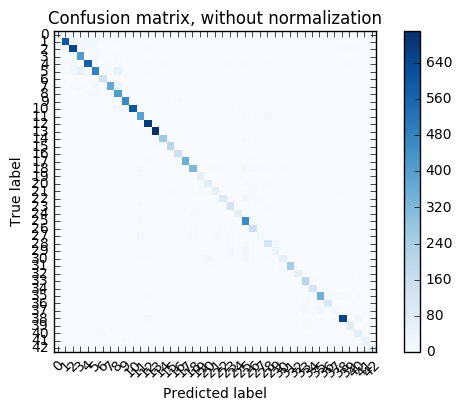

In [163]:
# confusion Matrix
# main idea: http://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrixhttp://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrixhttp://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix
import sklearn as sk
import itertools



confusionMatrix = sk.metrics.confusion_matrix(trueLabels, logitsTestAll)
#fpr, tpr, tresholds = sk.metrics.roc_curve(trueLabels, logitsTestAll)

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plotConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    '''thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")'''

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot non-normalized confusion matrix
plt.figure()
imgLabels = np.unique(train['labels'])
plotConfusionMatrix(confusionMatrix, classes=imgLabels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plotConfusionMatrix(confusionMatrix, classes=imgLabels, normalize=True,title='Normalized confusion matrix')
plt.show()

1438


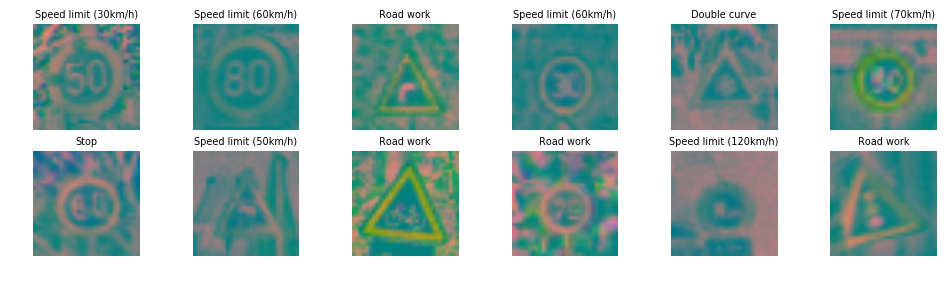

In [165]:
# plot wrong classified data
wrongIndex = np.where(trueLabels != logitsTestAll)
wrongIndexSize = wrongIndex[0].shape[0]
print(wrongIndexSize)
# plotting wrong predicted traffic signs images
%matplotlib inline
samples2Visualize = 12 # sample 10 random number
factors = [2,6] # indicate two factors for number of samples
assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
figure = plt.figure(figsize=(12,3))
for i in range(1,samples2Visualize+1):
    img = figure.add_subplot(factors[0],factors[1],i)
    # randomly sample an image from train set
    imgID = wrongIndex[0][np.random.randint(wrongIndexSize-1)]
    plt.imshow(testFeatures[imgID])
    # in case of grayscale
    #plt.imshow(testFeatures[imgID].reshape(testFeatures[imgID].shape[0],testFeatures[imgID].shape[1]))
    #img.set_title(imgTitles[train['labels'][imgID]],fontsize=7)
    img.set_title(imgTitles[logitsTestAll.astype(np.int64)[imgID]],fontsize=7)
    plt.axis('off')


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I will bring all of my 3 models here however in this notebook I used the third model. All of my models are based on convolutional neural network. 

Model 1:

input -> Conv2d->MaxPooling->Conv2d->MaxPooling->Conv2d->MaxPooling->Conv2d->MaxPooling -> FC1 -> [FC2] -> Softmax
Sizes:   32(5x5)             64(5x5)             128(5x5)            256(5x5)              1024   512      43

Model 2:

input -> Conv2d->Conv2d->MaxPooling->Conv2d->Conv2d->MaxPooling->Conv2d->Conv2d->MaxPooling -> FC1 -> [FC2] -> Softmax
Sizes:   32(7x7) 32(7x7)             64(5x5) 64(5x5)             128(4x4)128(4x4)              1024   512      43

Model 3:
         R/Y: Conv2d->MaxPooling->Conv2d->MaxPooling->Conv2D->MaxPooling
input -> G/U: Conv2d->MaxPooling->Conv2d->MaxPooling->Conv2D->MaxPooling  -> Flatten and Combine -> FC1 -> FC2 -> Softmax
         B/V: Conv2d->MaxPooling->Conv2d->MaxPooling->Conv2D->MaxPooling
Sizes:        64(3x3)             128(3x3)            256(3x3)                                       1024  512    43
         
Activation functions: Relu
Padding: Valid
Stride: 1
2x2 Max-Pooling
FC: Fully Connected
Dropout probability: 0.25
L2 Coefficient: 1e-1
Learning Rate: 9e-4

To prevent overfitting I used L2 Regularization to limit the weights and data augmenting. Unfortunately Dropout killed all the weights so I didn't use that amazing and powerful technique in my model however I know it is very helpful to use Dropout to prevent overfitting. I also removed the bias from the network to prevent overfitting.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I used Adam optimization and cross entropy to reduce the error of the network and train the weights for 75 epoch averagely with learning rate of 9e-4. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** First I start from a simple network and without even data augmentation or even data normalization then I design more models and I utilized more technique to help my models to prevent overfitting and achieve better accuracy. It was fun for me to tweak everything and check what can hlep me and what can make me feel bad.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [173]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2
import numpy as np
myTestImages =  []
rgbNormalization = True
for fileName in glob.glob('./elements/*.*'):
    print(fileName)
    img = cv2.imread(fileName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert bgr to rgb
    img = cv2.resize(img,(32,32)) # resize my images 
    if rgbNormalization == True:
        img = cv2.normalize(img, None, 0.0, 1.1, cv2.NORM_MINMAX, cv2.CV_32F)
    #plt.imshow(img)
    myTestImages.append(img)
myTestImagesNP = np.array(myTestImages)
print(myTestImagesNP.shape)    

./elements/IMG_20161213_211955.jpg
./elements/IMG_20161214_201436.jpg
./elements/sleipurvegur.jpg
./elements/IMG_20161213_113258.jpg
./elements/UK_traffic_sign_562.svg.png
./elements/IMG_20161214_203526.jpg
./elements/IMG_20161213_211327.jpg
./elements/IMG_20161214_201423.jpg
./elements/IMG_20161213_212122.jpg
./elements/IMG_20161213_211446.jpg
./elements/IMG_20161214_201442.jpg
./elements/IMG_20161214_201317.jpg
./elements/IMG_20161214_203528.jpg
./elements/IMG_20161213_211749.jpg
./elements/IMG_20161213_212202.jpg
./elements/UK_traffic_sign_632.svg.png
./elements/IMG_20161213_212533.jpg
./elements/UK_traffic_sign_562.svg (1).png
(18, 32, 32, 3)


In [174]:
newImgTitles = imgTitles
newImgTitles.append('Others')

In [175]:
print(len(newImgTitles))
print(newImgTitles)

47
['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vechiles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vechiles', 'Vechiles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vechiles over 3.5 metric tons', 'Oth

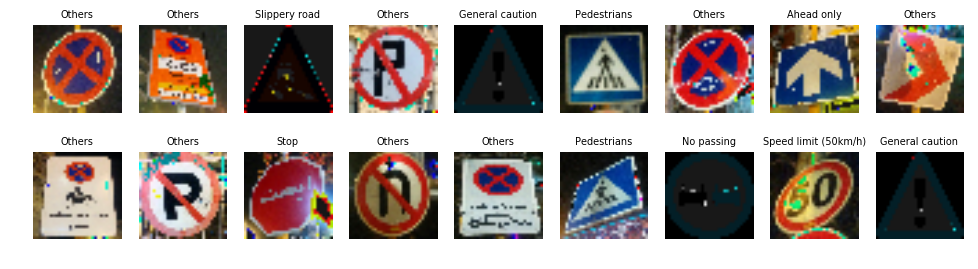

In [180]:
myTestLabels = [43,43,23,43,18,27,43,35,43,43,43,14,43,43,27,9,2,18]
myTestLabels = np.array(myTestLabels)
%matplotlib inline
samples2Visualize = 18 # sample 10 random number
factors = [2,9] # indicate two factors for number of samples
assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
figure = plt.figure(figsize=(12,3))
for i in range(1,samples2Visualize+1):
    img = figure.add_subplot(factors[0],factors[1],i)
    # randomly sample an image from train set
    imgID = i - 1
    plt.imshow(myTestImagesNP[imgID])
    img.set_title(newImgTitles[myTestLabels[imgID]],fontsize=7)
    plt.axis('off')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** I chose this local traffic sign to determine how my network will do with some kind of new data which didn't see before and I just wanna test the generalization capability of my models. It was good in one example which models learns to predict stop sign even with various and different languages(English and Persian). Some of the above pictures are not even in the 43 classes and I wanted to see how will the network perform with this new classes. 

In [184]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

#preprocess images
myTestImagesNP = np.array([bgr2YUV(image) for image in myTestImagesNP], dtype=np.float32)
myTestImagesNP = np.array([equlizeYUV(image) for image in myTestImagesNP], dtype=np.float32)


# Test model
logitsTestAll = np.zeros(myTestLabels.shape)

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(trainLabels)
myTestLabels = encoder.transform(myTestLabels)
# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
myTestLabels = myTestLabels.astype(np.float32)
batchX1 = np.array([myTestImagesNP[:,:,:,0].T]).T
batchX2 = np.array([myTestImagesNP[:,:,:,1].T]).T
batchX3 = np.array([myTestImagesNP[:,:,:,2].T]).T
predictC = sess.run(logits, feed_dict={x: myTestImagesNP, x1: batchX1, x2:batchX2, x3: batchX3, y: myTestLabels, keepProb: 1.0})
predicted = np.argmax(predictC, axis =1)
groundTruth = np.argmax(myTestLabels, axis=1) 
logitsTestAll = predicted
trueLabels = groundTruth    
accuracy = np.mean(np.equal(trueLabels,logitsTestAll).astype(np.float32))
print("Accuracy for my test set is ",accuracy)

Accuracy for my test set is  0.111111


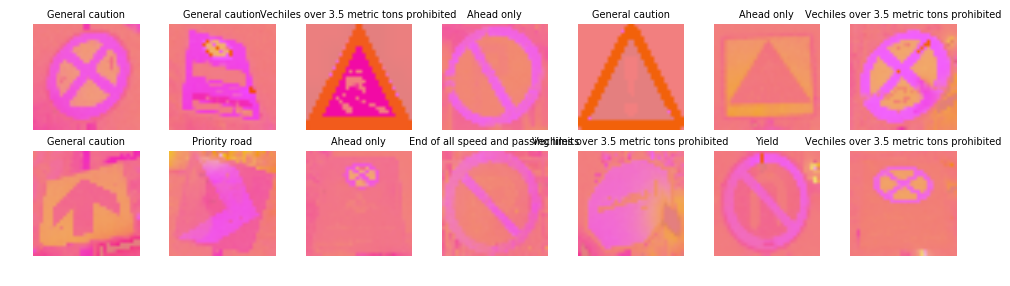

In [185]:
%matplotlib inline
samples2Visualize = 14 # sample 10 random number
factors = [2,7] # indicate two factors for number of samples
assert np.prod(np.array(factors))==samples2Visualize, "%rx%r is not equal to %r" % (factors[0],factors[1],samples2Visualize)
figure = plt.figure(figsize=(12,3))
for i in range(1,samples2Visualize+1):
    img = figure.add_subplot(factors[0],factors[1],i)
    # randomly sample an image from train set
    imgID = i - 1
    plt.imshow(myTestImagesNP[imgID])
    img.set_title(imgTitles[logitsTestAll[imgID]],fontsize=7)
    plt.axis('off')

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** Actually yes but I think my network need more generalization capability to work with a live camera stream because although it is very hard for all models to predict my special test set (most I captured them here in Iran) correctly however I think for a real system we need to train more and more with more computational power. 

In [186]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
# myTestLabels = [43,43,43,27,43,35,43,43,43,14,43,43,27,2]
certaintySamples = myTestImagesNP
top5 = sess.run(tf.nn.top_k(logits, k=5), feed_dict={x: certaintySamples, x1:batchX1, x2:batchX2, x3:batchX3})
print(top5)

TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[18,  0,  1,  2,  3],
       [18,  0,  1,  2,  3],
       [16,  0,  1,  2,  3],
       [35,  0,  1,  2,  3],
       [18,  0,  1,  2,  3],
       [35,  0,  1,  2,  3],
       [16,  0,  1,  2,  3],
       [18,  0,  1,  2,  3],
       [12,  0,  1,  2,  3],
       [35,  0,  1,  2,  3],
       [32,  0,  1,  2,  3],
       [16,  0,  1,  2,  3],
 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** According to above result yes my model is very certain about the results and I think this means I overfitted and I need utilize more overfitting prevention technique such as dropout. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** Everything is fully commented in my codes however first everything should be preprocessed and then just give them to the model, it will predict them like a jitter man ;D There is nothing comlicated to make necessary providing more documentation . 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.